In [2]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io,color,measure
import os
import glob
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM,Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import datetime

## Resize the images to (width,height)=(4000,2250)

### Test Images

In [ ]:
for i in range(1,6,1):
    path='/Users/kuladeep/AKAIKE/CV/data/test/image_'+str(i)+'.jpg'
    image=cv2.imread(path)
    new_image=cv2.resize(image,(4000,2250),interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(path,new_image)

### Train Images

In [ ]:
for i in os.listdir('train'):
    path='train/'+str(i)
    image=cv2.imread(path)
    new_image=cv2.resize(image,(4000,2250),interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(path,new_image)

### Watershed Algorithm on Train images

In [ ]:
"""
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html

This code performs grain size distribution analysis and dumps results into a csv file.
It uses watershed segmentation for better segmentation.
 
"""

# The glob.glob returns the list of files with their full path 
propList = ['Area',
            'equivalent_diameter',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            ]  
output_file = open('train.csv', 'w')
output_file.write('File_name'+ "," +"Label"+ "," + ",".join(propList) + '\n')
# join strings in array by commas. First column file name and 2nd column cell number 
# then join all names in prop list with a comma before their name. The go to next line.

path = "train/*.jpg"
for file in glob.glob(path):
    img1= cv2.imread(file)  
    img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    file_name=file.split('/')[1].split('.')[0]
    label=file.split('/')[1].split('.')[0].split('_')[0]
# Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Morphological operations to remove small noise - opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

# We need to extract sure regions. For that we can use erode. 
# But we have cells touching, so erode alone will not work. 
# To separate touching objects, the best approach would be distance transform and then thresholding.


# The area in between sure background and foreground is our ambiguous area. 
# Watershed should find this area for us. 
    sure_bg = cv2.dilate(opening,kernel,iterations=2)


# Finding sure foreground area using distance transform and thresholding
# https://www.tutorialspoint.com/opencv/opencv_distance_transformation.html

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)

    ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Unknown ambiguous region is nothing but bkground - foreground
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

# Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
# For markers let us use ConnectedComponents. 
    ret3, markers = cv2.connectedComponents(sure_fg)

# One problem rightnow is that the entire background pixels is given value 0.
# This means watershed considers this region as unknown.

    markers = markers+10

# Now, mark the region of unknown with zero
    markers[unknown==255] = 0

# Now we are ready for watershed filling. 
    markers = cv2.watershed(img1,markers)
# The boundary region will be marked -1
# https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1

# Let us color boundaries in yellow. 
    img1[markers == -1] = [0,255,255]  

    img2 = color.label2rgb(markers, bg_label=0)

# Now, time to extract properties of detected cells

    regions = measure.regionprops(markers, intensity_image=img)

    for region_props in regions:
        output_file.write(file_name + ',')
        if label=='full':
            output_file.write(str(1))
        elif label=='broken':
            output_file.write(str(0))
        else:
            output_file.write('mixed')
    # output cluster properties to the excel file
    # output_file.write(str(region_props['Label']))
        for i,prop in enumerate(propList):
            to_print = region_props[prop]     
            output_file.write(',' + str(to_print))
        output_file.write('\n')

output_file.close()   #Closes the file, otherwise it would be read only. 

### Visualize segmented images

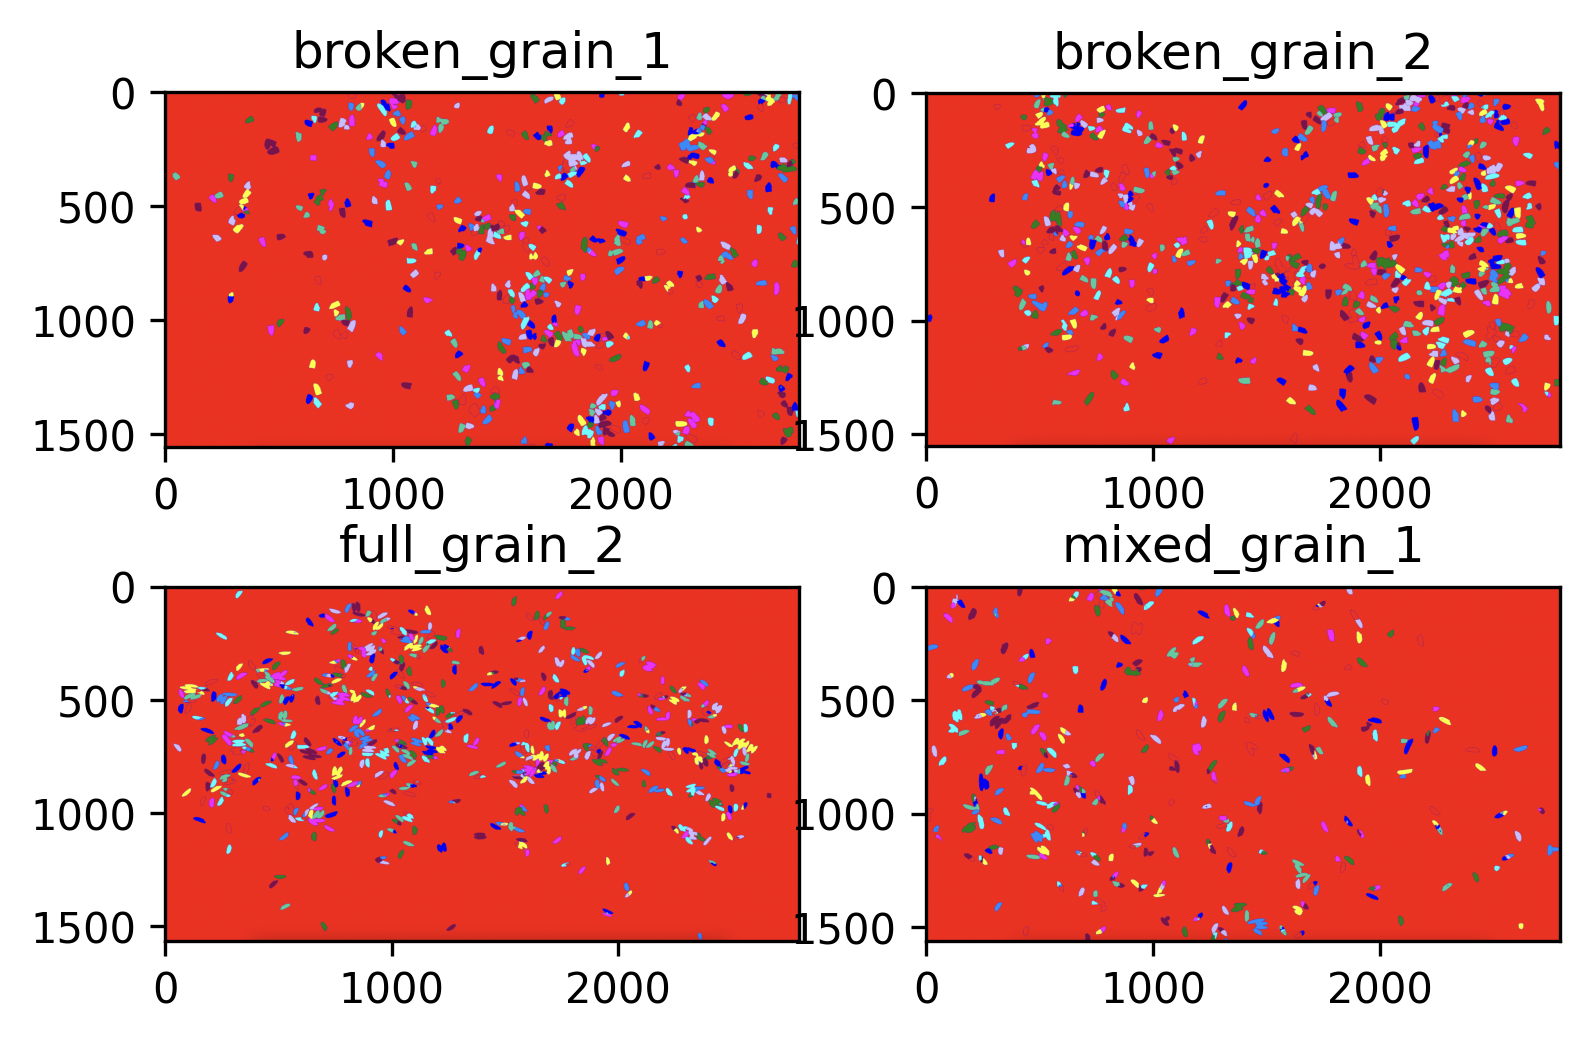

In [3]:
plt.rcParams['figure.dpi'] = 300
f, axarr = plt.subplots(2,2)
axarr[0,0].title.set_text('broken_grain_1')
img1=cv2.imread('/Users/kuladeep/AKAIKE/CV/data/labels/broken_grain_1.jpg')
axarr[0,0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axarr[0,1].title.set_text('broken_grain_2')
img2=cv2.imread('/Users/kuladeep/AKAIKE/CV/data/labels/broken_grain_2.jpg')
axarr[0,1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axarr[1,0].title.set_text('full_grain_2')
img3=cv2.imread('/Users/kuladeep/AKAIKE/CV/data/labels/full_grain_2.jpg')
axarr[1,0].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
axarr[1,1].title.set_text('mixed_grain_1')
img4=cv2.imread('/Users/kuladeep/AKAIKE/CV/data/labels/mixed_grain_1.jpg')
axarr[1,1].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
plt.show()

### Load CSV files created from above steps

In [ ]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

### Watershed Algorithm on test images

In [ ]:
propList = ['Area',
            'equivalent_diameter',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            ]  
output_file = open('test.csv', 'w')
output_file.write('File_name' +","+ ",".join(propList) + '\n')

path = "test/*.jpg"
for file in glob.glob(path):
    img1= cv2.imread(file)  
    img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    file_name=file.split('/')[1].split('.')[0]

    ret1, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

    sure_bg = cv2.dilate(opening,kernel,iterations=2)

    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)

    ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ret3, markers = cv2.connectedComponents(sure_fg)

    markers = markers+10

    markers[unknown==255] = 0

    markers = cv2.watershed(img1,markers)

    img1[markers == -1] = [0,255,255]  

    img2 = color.label2rgb(markers, bg_label=0)

# Now, time to extract properties of detected cells
    regions = measure.regionprops(markers, intensity_image=img)
 
    for region_props in regions:
        output_file.write(file_name)
        for i,prop in enumerate(propList):
            to_print = region_props[prop]     
            output_file.write(',' + str(to_print))
        output_file.write('\n')
output_file.close()   #Closes the file, otherwise it would be read only. 

### Remove outliers in this case Unsegmented clusters of grains

In [ ]:
path = "train/*.jpg"
outliers=[0]
for file in glob.glob(path):
    file_name=file.split('/')[1].split('.')[0]
    for i in range(99,101,1):
        outliers.append(int(np.percentile(df_train.loc[df_train['File_name']==file_name]['Area'],i)))

In [ ]:
df_train= df_train.replace(outliers, np.nan)
df_train= df_train.dropna().reset_index()

In [ ]:
df_train['Aspect_ratio']=df_train['MajorAxisLength']/df_train['MinorAxisLength']

### Create Labels

In [ ]:
# Full grains as one brokengrain as 0 
# mixed grains that have aspect ration<1.7 as 0 & >1.7 as 1
labels=[]
for i,j in df_train[['Label','Aspect_ratio']].values:
    if i=='mixed' and j>1.7:
        labels.append(1)
    elif i=='mixed' and j<=1.7:
        labels.append(0)
    elif i=='1':
        labels.append(1)
    else:
        labels.append(0)
df_train['Label']=labels      

In [ ]:
df_train=df_train.drop('index',axis=1)

In [ ]:
df_train.head()

,File_name,Label,Area,equivalent_diameter,MajorAxisLength,MinorAxisLength,Perimeter,Aspect_ration,Aspect_ratio
0,mixed_grains_3,0,1486.0,43.497517,71.066761,28.362790,196.195959,2.505634,2.505634
1,mixed_grains_3,0,3257.0,64.396748,108.902258,40.635621,304.398016,2.679970,2.679970
2,mixed_grains_3,0,1170.0,38.596506,58.821235,27.235363,156.811183,2.159737,2.159737
3,mixed_grains_3,0,3368.0,65.484890,103.164967,42.373555,250.225397,2.434655,2.434655
4,mixed_grains_3,0,4075.0,72.030904,118.488946,44.578563,301.942172,2.657980,2.657980


In [ ]:
path = "test/*.jpg"
outliers=[0]
for file in glob.glob(path):
    file_name=file.split('/')[1].split('.')[0]
    for i in range(99,101,1):
        outliers.append(int(np.percentile(df_test.loc[df_test['File_name']==file_name]['Area'],i)))

In [ ]:
df_test= df_test.replace(outliers, np.nan)
df_test= df_test.dropna().reset_index()

In [ ]:
df_test['Aspect_ratio']=df_test['MajorAxisLength']/df_test['MinorAxisLength']

In [ ]:
df_test.drop('index',axis=1)

,File_name,Area,equivalent_diameter,MajorAxisLength,MinorAxisLength,Perimeter,Aspect_ratio
0,image_2,639.0,28.523676,38.703845,22.872407,103.633514,1.692163
1,image_2,2379.0,55.036687,81.098679,39.739260,222.811183,2.040770
2,image_2,922.0,34.262616,60.557580,20.036772,138.662951,3.022322
3,image_2,1302.0,40.715573,61.884437,27.557154,156.568542,2.245676
4,image_2,3385.0,65.649949,118.366177,55.412341,357.362482,2.136098
...,...,...,...,...,...,...,...
3183,image_5,95.0,10.998080,14.427088,9.544767,45.284271,1.511518
3184,image_5,1823.0,48.177959,72.875829,36.252535,244.521861,2.010227
3185,image_5,1599.0,45.121060,70.664009,31.225391,194.468037,2.263030
3186,image_5,972.0,35.179381,42.886867,30.707546,131.497475,1.396623


### Train Test split

In [43]:
X=df_train.drop(['Label','File_name'],axis=1)
y=df_train['Label'].values

In [55]:
# Normalize the columns
X=(X-X.mean())/X.std()

In [56]:
X_train, X_cv, y_train, y_cv = train_test_split(X,y ,stratify=y, test_size=0.20,random_state=33)

### Train neural network to seperate full grains and broken grains

In [57]:

#tensorboard callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)
input_layer=Input(shape=(X_train.shape[1],))
dense1=Dense(384, activation='relu')(input_layer)
dense2=Dense(192, activation='relu')(dense1)
drop1=Dropout(0.2)(dense2)
dense3=Dense(64, activation='sigmoid')(drop1)
output_layer=Dense(2, activation='softmax')(dense3)
model_nn= Model(inputs=[input_layer], outputs=output_layer)
optimizer = tf.keras.optimizers.Adam()
model_nn.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
# summarize layers
print(model_nn.summary())


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_22 (Dense)            (None, 384)               2688      
                                                                 
 dense_23 (Dense)            (None, 192)               73920     
                                                                 
 dropout_4 (Dropout)         (None, 192)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                12352     
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
Total params: 89,090
Trainable params: 89,090
Non-trainable

In [58]:
model_nn.fit(X_train,y_train,epochs=20,validation_data=(X_cv,y_cv),callbacks=tensorboard_callback)

Epoch 1/20
150/150 [==============================] - 1s 4ms/step - loss: 0.4618 - accuracy: 0.7967 - val_loss: 0.4268 - val_accuracy: 0.8159
Epoch 2/20
150/150 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.8197 - val_loss: 0.4153 - val_accuracy: 0.8109
Epoch 3/20
150/150 [==============================] - 0s 3ms/step - loss: 0.4057 - accuracy: 0.8215 - val_loss: 0.4041 - val_accuracy: 0.8209
Epoch 4/20
150/150 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.8215 - val_loss: 0.4050 - val_accuracy: 0.8243
Epoch 5/20
150/150 [==============================] - 1s 3ms/step - loss: 0.4000 - accuracy: 0.8220 - val_loss: 0.4095 - val_accuracy: 0.8234
Epoch 6/20
150/150 [==============================] - 0s 3ms/step - loss: 0.3973 - accuracy: 0.8238 - val_loss: 0.4110 - val_accuracy: 0.8167
Epoch 7/20
150/150 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8230 - val_loss: 0.4039 - val_accuracy: 0.8192
Epoch 

## Normalize Test data

In [59]:
X_test=df_test.drop('File_name',axis=1)
X_test=(X_test-X_test.mean())/X_test.std()
y_pred=model_nn.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)

In [66]:
df_test['predicted']=y_pred

In [68]:
final_df=pd.read_csv('submission.csv')

In [80]:
df_total_rice_grain=df_test[['File_name','Area']].groupby('File_name').count().rename(columns={'Area':'total_rice_grain'}).reset_index()

In [81]:
df_total_broken_rice_grain=df_test[['File_name','Area']].loc[df_test['predicted']==0].groupby('File_name').count().reset_index().rename(columns={'Area':'total_broken_rice_grain'})

In [82]:
final_df['total_rice_grain']=df_total_rice_grain['total_rice_grain']
final_df['total_broken_rice_grain']=df_total_broken_rice_grain['total_broken_rice_grain']

In [83]:
final_df

,file_name,total_rice_grain,total_broken_rice_grain
0,image_1.jpg,646,136
1,image_2.jpg,535,164
2,image_3.jpg,563,210
3,image_4.jpg,779,231
4,image_5.jpg,661,209


In [84]:
final_df.to_csv('submission.csv',index=False)